# EDA

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer,
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier

SEED = 53188535

## There are three potential datasets for this project:

### ~9k Myers-Briggs Personality Type labeled comments from PersonalityCafe

In [7]:
cafe_df = pd.read_csv('data/mbti_1.csv')

In [8]:
cafe_df

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...
...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...
8671,ENFP,'So...if this thread already exists someplace ...
8672,INTP,'So many questions when i do these things. I ...
8673,INFP,'I am very conflicted right now when it comes ...


### ~100k Myers-Briggs Personality Type labeled comments from PersonalityCafe and Google Big Query Reddit users. 
Posts are preprocessed texts:

- No punctuations, stopwords, URLs
- Lemmatization
- Reconstruct samples to be equal-sized chunks (500 words per sample)

In [286]:
both_df = pd.read_csv('data/MBTI 500.csv')

### ~1.7M Google Big Query of Reddit comments and their Myers-Briggs Personality Type

In [287]:
gbq_df = pd.read_csv('data/mbti_full_pull.csv')

In [288]:
whitelist = ['intp', 'intj', 'entp', 'entj', 'infj', 'infp', 'enfj', 'enfp', 'istj', 'isfj', 'estj', 'esfj', 'istp', 'isfp', 'estp', 'esfp']

## Personality Cafe
For the baseline, will use the Peronality Cafe Data.

In [9]:
# Creating list of all the variables for Myers_Briggs type for future use.
pred_lst = ['intp', 'intj', 'entp', 'entj', 'infj', 'infp', 'enfj', \
    'enfp', 'istj', 'isfj', 'estj', 'esfj', 'istp', 'isfp', 'estp', 'esfp']

pred_st = set(''.join(pred_lst))

In [10]:
cafe_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [11]:
cafe_df.type.value_counts(normalize=True)

INFP    0.211182
INFJ    0.169452
INTP    0.150317
INTJ    0.125764
ENTP    0.078963
ENFP    0.077810
ISTP    0.038847
ISFP    0.031239
ENTJ    0.026628
ISTJ    0.023631
ENFJ    0.021902
ISFJ    0.019135
ESTP    0.010259
ESFP    0.005533
ESFJ    0.004841
ESTJ    0.004496
Name: type, dtype: float64

### Clean & Preprocess

In [12]:
cafe_clean = cafe_df.copy()

In [13]:
import re
import string

In [14]:
punc = string.punctuation

In [15]:
cafe_clean['type'] = cafe_clean.type.str.lower()

In [16]:
cafe_clean['clean_posts'] = cafe_clean.posts.str.lower()

In [17]:
def url_remove(post):
    return re.sub(r'http\S+', '', post)

def pipe_remove(post):
    return re.sub(r'[|]', ' ', post)

def punc_remove(post):
    return re.sub(r'[\'_:]', '', post)

def remove_dig_token(post):
    return [post[i] for i in range(len(post)) if post[i].isalpha()]

def remove_stopwords(post):
    sw = stopwords.words('english')
    return [post[i] for i in range(len(post)) if post[i] not in sw]

In [18]:
cafe_clean['clean_posts'] = cafe_clean['clean_posts'].apply(pipe_remove)

In [19]:
cafe_clean['clean_posts'] = cafe_clean['clean_posts'].apply(url_remove)

In [20]:
cafe_clean['clean_posts'] = cafe_clean['clean_posts'].apply(punc_remove)

In [21]:
cafe_clean.iloc[2, 2]

'good one        of course, to which i say i know; thats my blessing and my curse.   does being absolutely positive that you and your best friend could be an amazing couple count? if so, than yes.   or its more i could be madly in love in case i reconciled my feelings (which at...   no, i didnt; thank you for a link!   so-called ti-si loop (and it can stem from any current topic/obsession) can be deadly. its like when youre stuck in your own thoughts, and your mind just wanders in circles. feels truly terrible. ...   have you noticed how peculiar vegetation can be? all you have to do is look down at the grass dozens of different plant species there.    and now imagine that hundreds of years later (when/if soil...   the smiths – never had no one ever   i often find myself spotting faces on marble tiles/wood.   this 5 year-old sentence is an incredibly accurate and beautiful description.   i havent visited this website in the last 3 years. so whoever reads this (and maybe even remembers 

In [22]:
pattern = r"(?u)\b\w\w+\b"

In [23]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(pattern)

In [24]:
cafe_clean['post_token'] = cafe_clean['clean_posts'].apply(tokenizer.tokenize)

In [25]:
cafe_clean['post_token'] = cafe_clean['post_token'].apply(remove_dig_token)

In [26]:
cafe_clean['post_token'] = cafe_clean['post_token'].apply(remove_stopwords)

In [27]:
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_text(tokens):
    return [lemmatizer.lemmatize(w) for w in tokens]

In [28]:
cafe_clean['post_token'] = cafe_clean['post_token'].apply(lemmatize_text)

In [29]:
def join_tokens(tokens):
    long_string = ' '.join(tokens)
    return long_string

In [30]:
cafe_clean['token_joined'] = cafe_clean['post_token'].apply(join_tokens)

In [31]:
cafe_clean['clean_posts'] = cafe_clean['post_token'].str.join(' ')

In [32]:
cafe_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   type          8675 non-null   object
 1   posts         8675 non-null   object
 2   clean_posts   8675 non-null   object
 3   post_token    8675 non-null   object
 4   token_joined  8675 non-null   object
dtypes: object(5)
memory usage: 339.0+ KB


In [33]:
cafe_clean.head(5)

,type,posts,clean_posts,post_token,token_joined
0,infj,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,enfp intj moment sportscenter top ten play pra...,"[enfp, intj, moment, sportscenter, top, ten, p...",enfp intj moment sportscenter top ten play pra...
1,entp,'I'm finding the lack of me in these posts ver...,im finding lack post alarming sex boring posit...,"[im, finding, lack, post, alarming, sex, borin...",im finding lack post alarming sex boring posit...
2,intp,'Good one _____ https://www.youtube.com/wat...,good one course say know thats blessing curse ...,"[good, one, course, say, know, thats, blessing...",good one course say know thats blessing curse ...
3,intj,"'Dear INTP, I enjoyed our conversation the o...",dear intp enjoyed conversation day esoteric ga...,"[dear, intp, enjoyed, conversation, day, esote...",dear intp enjoyed conversation day esoteric ga...
4,entj,'You're fired.|||That's another silly misconce...,youre fired thats another silly misconception ...,"[youre, fired, thats, another, silly, misconce...",youre fired thats another silly misconception ...


### Adding binary targets

In [34]:
cafe_clean['i/e'] = cafe_clean['type'].map(lambda x: x[0])
cafe_clean['n/s'] = cafe_clean['type'].map(lambda x: x[1])
cafe_clean['t/f'] = cafe_clean['type'].map(lambda x: x[2])
cafe_clean['p/j'] = cafe_clean['type'].map(lambda x: x[3])


In [318]:
print(cafe_clean['i/e'].value_counts())
print(cafe_clean['n/s'].value_counts())
print(cafe_clean['t/f'].value_counts())
print(cafe_clean['p/j'].value_counts())

i    6676
e    1999
Name: i/e, dtype: int64
n    7478
s    1197
Name: n/s, dtype: int64
f    4694
t    3981
Name: t/f, dtype: int64
p    5241
j    3434
Name: p/j, dtype: int64


In [319]:
cafe_clean

,type,posts,clean_posts,post_token,token_joined,i/e,n/s,t/f,p/j
0,infj,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,enfp intj moment sportscenter top ten play pra...,"[enfp, intj, moment, sportscenter, top, ten, p...",enfp intj moment sportscenter top ten play pra...,i,n,f,j
1,entp,'I'm finding the lack of me in these posts ver...,im finding lack post alarming sex boring posit...,"[im, finding, lack, post, alarming, sex, borin...",im finding lack post alarming sex boring posit...,e,n,t,p
2,intp,'Good one _____ https://www.youtube.com/wat...,good one course say know thats blessing curse ...,"[good, one, course, say, know, thats, blessing...",good one course say know thats blessing curse ...,i,n,t,p
3,intj,"'Dear INTP, I enjoyed our conversation the o...",dear intp enjoyed conversation day esoteric ga...,"[dear, intp, enjoyed, conversation, day, esote...",dear intp enjoyed conversation day esoteric ga...,i,n,t,j
4,entj,'You're fired.|||That's another silly misconce...,youre fired thats another silly misconception ...,"[youre, fired, thats, another, silly, misconce...",youre fired thats another silly misconception ...,e,n,t,j
...,...,...,...,...,...,...,...,...,...
8670,isfp,'https://www.youtube.com/watch?v=t8edHB_h908||...,ixfp always think cat fi doms reason especiall...,"[ixfp, always, think, cat, fi, doms, reason, e...",ixfp always think cat fi doms reason especiall...,i,s,f,p
8671,enfp,'So...if this thread already exists someplace ...,thread already exists someplace else heck dele...,"[thread, already, exists, someplace, else, hec...",thread already exists someplace else heck dele...,e,n,f,p
8672,intp,'So many questions when i do these things. I ...,many question thing would take purple pill pic...,"[many, question, thing, would, take, purple, p...",many question thing would take purple pill pic...,i,n,t,p
8673,infp,'I am very conflicted right now when it comes ...,conflicted right come wanting child honestly m...,"[conflicted, right, come, wanting, child, hone...",conflicted right come wanting child honestly m...,i,n,f,p


### Baseline Models

In [320]:
X = cafe_clean['token_joined']
y = cafe_clean['type']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

In [321]:
count_vc = CountVectorizer(ngram_range=(1,2))

In [322]:
X_train_count = count_vc.fit_transform(X_train)
X_test_count = count_vc.transform(X_test)

In [323]:
sgd = SGDClassifier(class_weight='balanced', random_state=SEED)

sgd.fit(X_train_count, y_train)

cv_score = cross_val_score(sgd, X_train_count, y_train, cv=5)
cv_score_mean = round(np.mean(cv_score), 4)

y_pred = sgd.predict(X_test_count)
acc_score = accuracy_score(y_pred, y_test)

print(f"CV: {cv_score_mean}, A: {acc_score}")

CV: 0.6156, A: 0.5984324573536192


In [324]:
y_test.value_counts(normalize=True)

infp    0.203781
infj    0.174735
intp    0.171047
intj    0.132319
enfp    0.072845
          ...   
isfj    0.017981
estp    0.011526
estj    0.005994
esfp    0.005533
esfj    0.004610
Name: type, Length: 16, dtype: float64

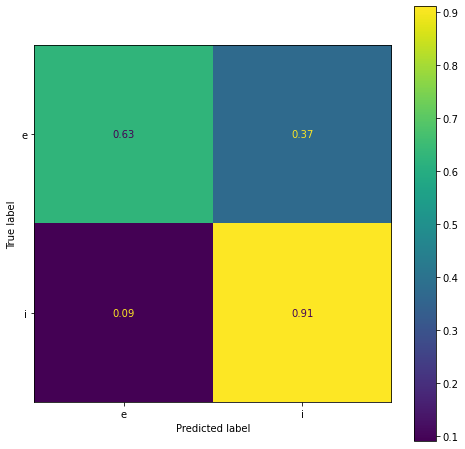

In [43]:
fig, ax = plt.subplots(figsize=(8,8))
plot_confusion_matrix(sgd, X_test_count, y_test, ax=ax, normalize='true')

In [44]:
# BASELINE
# ---------
# All classes ~60%
# i/e ~85%
# n/s ~90%
# p/j ~77%
# t/f ~85%

### Understample test set for binary

In [45]:
from imblearn.under_sampling import RandomUnderSampler

In [46]:
train_set, test_set = train_test_split(cafe_clean, random_state=SEED)

X_train = train_set['token_joined']
X_train = np.array(X_train).reshape(-1, 1)

y_train = train_set['t/f']
y_train = np.array(y_train).reshape(-1, 1)


# instantiating the random undersampler
rus = RandomUnderSampler() 

# resampling training set X & y
X_rus, y_rus = rus.fit_resample(X_train, y_train)

# new class distribution
print(np.unique(y_train, return_counts=True))
print(np.unique(y_rus, return_counts=True))

(array(['f', 't'], dtype=object), array([3544, 2962]))
(array(['f', 't'], dtype=object), array([2962, 2962]))


In [47]:
X_rus.reshape(-1).shape

(5924,)

In [48]:
X_rus = pd.Series(X_rus.reshape(-1))
y_rus = pd.Series(y_rus.reshape(-1))

In [49]:
X_train_count = count_vc.fit_transform(X_rus)
X_test_count = count_vc.transform(test_set['token_joined'])

In [50]:
sgd = SGDClassifier(class_weight='balanced', random_state=SEED)

sgd.fit(X_train_count, y_rus)

cv_score = cross_val_score(sgd, X_train_count, y_rus, cv=5)
cv_score_mean = round(np.mean(cv_score), 4)

y_pred = sgd.predict(X_test_count)
acc_score = accuracy_score(y_pred, test_set['t/f'])

print(f"CV: {cv_score_mean}, A: {acc_score}")

CV: 0.8304, A: 0.8377132319041033


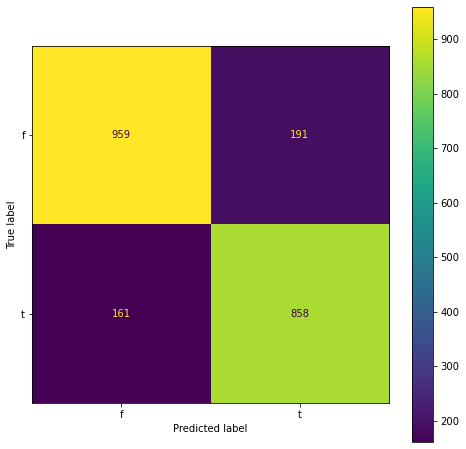

In [51]:
fig, ax = plt.subplots(figsize=(8,8))
plot_confusion_matrix(sgd, X_test_count, test_set['t/f'], ax=ax)

In [52]:
# Undersampling
# ---------
# i/e ~81%
# n/s ~83%
# p/j ~76%
# t/f ~83%

## Both DF

Comparing baseline models to this other dataset

In [53]:
both_clean = both_df.copy()

In [54]:
both_clean['type'] = both_clean['type'].str.lower()

In [55]:
both_clean['type'].value_counts()

intp    24961
intj    22427
infj    14963
infp    12134
entp    11725
enfp     6167
istp     3424
entj     2955
estp     1986
enfj     1534
istj     1243
isfp      875
isfj      650
estj      482
esfp      360
esfj      181
Name: type, dtype: int64

In [56]:
both_clean['i/e'] = both_clean['type'].map(lambda x: x[0])
both_clean['n/s'] = both_clean['type'].map(lambda x: x[1])
both_clean['t/f'] = both_clean['type'].map(lambda x: x[2])
both_clean['p/j'] = both_clean['type'].map(lambda x: x[3])


In [57]:
print(both_clean['i/e'].value_counts())
print(both_clean['n/s'].value_counts())
print(both_clean['t/f'].value_counts())
print(both_clean['p/j'].value_counts())

i    80677
e    25390
Name: i/e, dtype: int64
n    96866
s     9201
Name: n/s, dtype: int64
t    69203
f    36864
Name: t/f, dtype: int64
p    61632
j    44435
Name: p/j, dtype: int64


In [58]:
both_clean.columns

Index(['posts', 'type', 'i/e', 'n/s', 't/f', 'p/j'], dtype='object')

In [59]:
X = both_clean['posts']
y = both_clean['type']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

In [60]:
count_vc = CountVectorizer(ngram_range=(1,2))

In [61]:
X_train_count = count_vc.fit_transform(X_train)
X_test_count = count_vc.transform(X_test)

In [62]:
sgd = SGDClassifier(class_weight='balanced', random_state=SEED)

sgd.fit(X_train_count, y_train)

cv_score = cross_val_score(sgd, X_train_count, y_train, cv=5)
cv_score_mean = round(np.mean(cv_score), 4)

y_pred = sgd.predict(X_test_count)
acc_score = accuracy_score(y_pred, y_test)

print(f"CV: {cv_score_mean}, A: {round(acc_score, 4)}")

CV: 0.9213, A: 0.9251


In [63]:
y_test.value_counts(normalize=True)

t    0.653204
f    0.346796
Name: t/f, dtype: float64

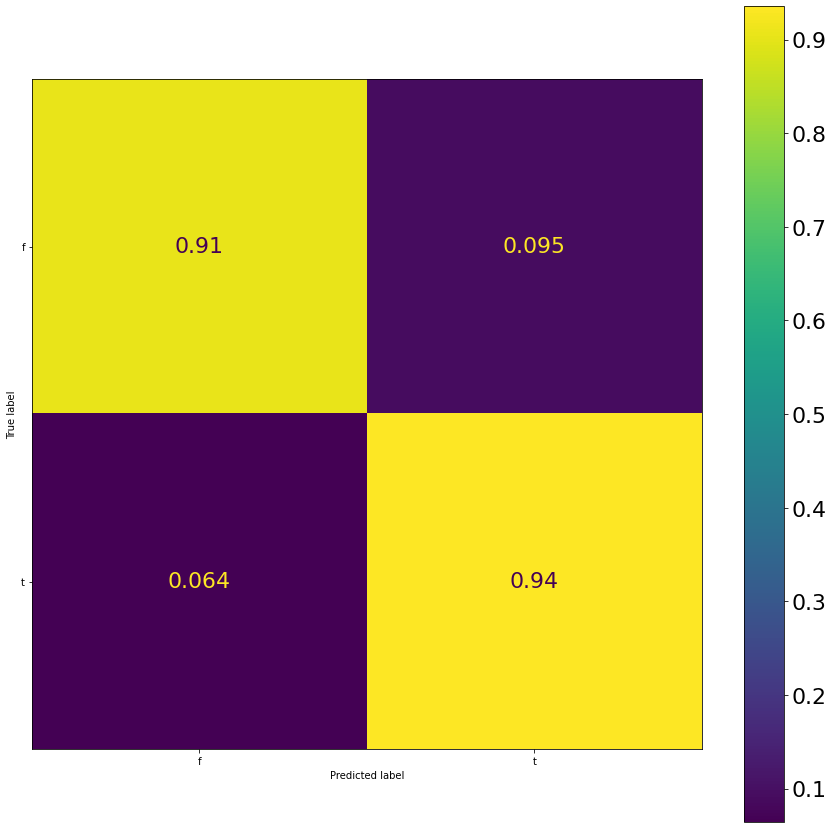

In [64]:
fig, ax = plt.subplots(figsize=(15,15))
plt.rcParams.update({'font.size': 22})
plt.rc('xtick', labelsize=22) 
plt.rc('ytick', labelsize=22) 
plot_confusion_matrix(sgd, X_test_count, y_test, ax=ax, normalize='true')

In [65]:
# BASELINE (100k set)
# ---------
# All ~82%
# i/e ~85%
# n/s ~96%
# p/j ~86%
# t/f ~92%

# BASELINE (Cafe 9k set)
# ---------
# All classes ~60%
# i/e ~85%
# n/s ~90%
# p/j ~77%
# t/f ~85%

# Undersampling (Cafe)
# ---------
# i/e ~81%
# n/s ~83%
# p/j ~76%
# t/f ~83%



## Google Big Query

In [360]:
gbq_clean = gbq_df.copy()

In [361]:
gbq_clean['author_flair_text'] = gbq_clean['author_flair_text'].str.lower()
gbq_clean['subreddit'] = gbq_clean['subreddit'].str.lower()

In [362]:
whitelist
regex_mbti = '|'.join(["(" + i + ")" for i in whitelist])

In [363]:
regex_mbti

'(intp)|(intj)|(entp)|(entj)|(infj)|(infp)|(enfj)|(enfp)|(istj)|(isfj)|(estj)|(esfj)|(istp)|(isfp)|(estp)|(esfp)'

In [364]:
for mbti in whitelist:
    gbq_clean['author_flair_text'] = gbq_clean['author_flair_text'].mask(gbq_clean['author_flair_text'].str.match("(?:" + mbti + ")"), mbti)

In [145]:
# gbq_clean['author_flair_text'] = gbq_clean['author_flair_text'].mask(gbq_clean['author_flair_text'].str.match(r"\b-infj", case=False), 'infj')

In [366]:
gbq_clean = gbq_clean[gbq_clean['author_flair_text'].str.match(regex_mbti)]

In [367]:
gbq_clean['author_flair_text'].value_counts().to_frame('counts')

,counts
intp,425910
intj,346064
infp,164822
infj,164145
entp,141526
...,...
estp,9608
esfp,5851
isfj,5609
estj,3854


In [368]:
gbq_clean['i/e'] = gbq_clean['author_flair_text'].map(lambda x: x[0])
gbq_clean['n/s'] = gbq_clean['author_flair_text'].map(lambda x: x[1])
gbq_clean['t/f'] = gbq_clean['author_flair_text'].map(lambda x: x[2])
gbq_clean['p/j'] = gbq_clean['author_flair_text'].map(lambda x: x[3])

In [369]:
gbq_clean.columns[-4:]

Index(['i/e', 'n/s', 't/f', 'p/j'], dtype='object')

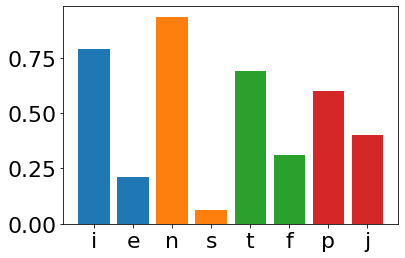

In [370]:
for column in gbq_clean.columns[-4:]:
    plt.bar(gbq_clean[column].value_counts(normalize=True).index, gbq_clean[column].value_counts(normalize=True).values)

In [371]:
gbq_clean

,author_flair_text,body,subreddit,i/e,n/s,t/f,p/j
0,intj,Knowing you're in INTJ is a tool for you to us...,intj,i,n,t,j
1,intj,You are truly an enlightened mastermind.,intj,i,n,t,j
2,infj,You should :) it will help if you have a down ...,infj,i,n,f,j
3,intp,I watch a bit of everything (including hentai)...,intp,i,n,t,p
4,intj,I don't know if I would count this as a pet pe...,intj,i,n,t,j
...,...,...,...,...,...,...,...
1794011,intp,Remind me! 40 hours,intp,i,n,t,p
1794012,intj,We are seeing the start of a process that is g...,intj,i,n,t,j
1794013,intj,[NSFDL. I cry laughing at this every single ti...,intj,i,n,t,j
1794014,infj,Ravenclaw!,infj,i,n,f,j


In [372]:
from text_clean import preprocess

In [373]:
tc = preprocess()

In [374]:
gbq_clean = gbq_clean.dropna()

In [375]:
gbq_clean['body'] = gbq_clean['body'].str.lower()

<ipython-input-375-e8ecf0d96943>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gbq_clean['body'] = gbq_clean['body'].str.lower()


In [376]:
gbq_clean

,author_flair_text,body,subreddit,i/e,n/s,t/f,p/j
0,intj,knowing you're in intj is a tool for you to us...,intj,i,n,t,j
1,intj,you are truly an enlightened mastermind.,intj,i,n,t,j
2,infj,you should :) it will help if you have a down ...,infj,i,n,f,j
3,intp,i watch a bit of everything (including hentai)...,intp,i,n,t,p
4,intj,i don't know if i would count this as a pet pe...,intj,i,n,t,j
...,...,...,...,...,...,...,...
1794011,intp,remind me! 40 hours,intp,i,n,t,p
1794012,intj,we are seeing the start of a process that is g...,intj,i,n,t,j
1794013,intj,[nsfdl. i cry laughing at this every single ti...,intj,i,n,t,j
1794014,infj,ravenclaw!,infj,i,n,f,j


In [377]:
gbq_clean['clean_posts'] = gbq_clean['body'].apply(pipe_remove)
gbq_clean['clean_posts'] = gbq_clean['body'].apply(url_remove)
gbq_clean['clean_posts'] = gbq_clean['body'].apply(punc_remove)

<ipython-input-377-1da51874eb79>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gbq_clean['clean_posts'] = gbq_clean['body'].apply(pipe_remove)
<ipython-input-377-1da51874eb79>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gbq_clean['clean_posts'] = gbq_clean['body'].apply(url_remove)
<ipython-input-377-1da51874eb79>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

In [378]:
pattern = r"(?u)\b\w\w+\b"

In [379]:
tokenizer = RegexpTokenizer(pattern)

In [380]:
gbq_clean['post_token'] = gbq_clean['clean_posts'].apply(tokenizer.tokenize)

<ipython-input-380-4abedb3aa4f4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gbq_clean['post_token'] = gbq_clean['clean_posts'].apply(tokenizer.tokenize)


In [382]:
gbq_clean['post_token'] = gbq_clean['post_token'].apply(remove_dig_token)

<ipython-input-382-6b1b40f995c8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gbq_clean['post_token'] = gbq_clean['post_token'].apply(remove_dig_token)


In [383]:
gbq_clean

,author_flair_text,body,subreddit,i/e,n/s,t/f,p/j,clean_posts,post_token
0,intj,knowing you're in intj is a tool for you to us...,intj,i,n,t,j,knowing youre in intj is a tool for you to use...,"[knowing, youre, in, intj, is, tool, for, you,..."
1,intj,you are truly an enlightened mastermind.,intj,i,n,t,j,you are truly an enlightened mastermind.,"[you, are, truly, an, enlightened, mastermind]"
2,infj,you should :) it will help if you have a down ...,infj,i,n,f,j,you should ) it will help if you have a down m...,"[you, should, it, will, help, if, you, have, d..."
3,intp,i watch a bit of everything (including hentai)...,intp,i,n,t,p,i watch a bit of everything (including hentai)...,"[watch, bit, of, everything, including, hentai..."
4,intj,i don't know if i would count this as a pet pe...,intj,i,n,t,j,i dont know if i would count this as a pet pee...,"[dont, know, if, would, count, this, as, pet, ..."
...,...,...,...,...,...,...,...,...,...
1794011,intp,remind me! 40 hours,intp,i,n,t,p,remind me! 40 hours,"[remind, me, hours]"
1794012,intj,we are seeing the start of a process that is g...,intj,i,n,t,j,we are seeing the start of a process that is g...,"[we, are, seeing, the, start, of, process, tha..."
1794013,intj,[nsfdl. i cry laughing at this every single ti...,intj,i,n,t,j,[nsfdl. i cry laughing at this every single ti...,"[nsfdl, cry, laughing, at, this, every, single..."
1794014,infj,ravenclaw!,infj,i,n,f,j,ravenclaw!,[ravenclaw]


In [385]:
gbq_clean['post_token'] = gbq_clean['post_token'].apply(remove_stopwords)

<ipython-input-385-55d595cb61ff>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gbq_clean['post_token'] = gbq_clean['post_token'].apply(remove_stopwords)


In [386]:
gbq_clean['post_token'] = gbq_clean['post_token'].apply(lemmatize_text)

<ipython-input-386-5790d1a470d1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gbq_clean['post_token'] = gbq_clean['post_token'].apply(lemmatize_text)


In [387]:
gbq_clean = gbq_clean[gbq_clean['post_token'].apply(lambda x: len(x) > 5)]

In [388]:
gbq_clean['token_joined'] = gbq_clean['post_token'].apply(join_tokens)

<ipython-input-388-16f839d5e7f7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gbq_clean['token_joined'] = gbq_clean['post_token'].apply(join_tokens)


In [389]:
gbq_clean

,author_flair_text,body,subreddit,i/e,n/s,t/f,p/j,clean_posts,post_token,token_joined
0,intj,knowing you're in intj is a tool for you to us...,intj,i,n,t,j,knowing youre in intj is a tool for you to use...,"[knowing, youre, intj, tool, use, interaction,...",knowing youre intj tool use interaction people...
2,infj,you should :) it will help if you have a down ...,infj,i,n,f,j,you should ) it will help if you have a down m...,"[help, moment, hobby, keep, mind, busy, dont, ...",help moment hobby keep mind busy dont like loo...
3,intp,i watch a bit of everything (including hentai)...,intp,i,n,t,p,i watch a bit of everything (including hentai)...,"[watch, bit, everything, including, hentai, te...",watch bit everything including hentai tend enj...
4,intj,i don't know if i would count this as a pet pe...,intj,i,n,t,j,i dont know if i would count this as a pet pee...,"[dont, know, would, count, pet, peeze, somethi...",dont know would count pet peeze something time...
5,intp,"ah. \nnot sure how se works for other types, b...",infj,i,n,t,p,"ah. \nnot sure how se works for other types, b...","[ah, sure, se, work, type, intp, play, role, o...",ah sure se work type intp play role organizing...
...,...,...,...,...,...,...,...,...,...,...
1794009,intj,"agree. especially with the beatles (""a day in...",intj,i,n,t,j,"agree. especially with the beatles (""a day in...","[agree, especially, beatles, day, life, tomorr...",agree especially beatles day life tomorrow nev...
1794010,infj,yes!!! i experience extreme anxiety at the gym...,infj,i,n,f,j,yes!!! i experience extreme anxiety at the gym...,"[yes, experience, extreme, anxiety, gym, busy,...",yes experience extreme anxiety gym busy find s...
1794012,intj,we are seeing the start of a process that is g...,intj,i,n,t,j,we are seeing the start of a process that is g...,"[seeing, start, process, going, food, historia...",seeing start process going food historian cent...
1794013,intj,[nsfdl. i cry laughing at this every single ti...,intj,i,n,t,j,[nsfdl. i cry laughing at this every single ti...,"[nsfdl, cry, laughing, every, single, time, ht...",nsfdl cry laughing every single time http yout...


In [390]:
gbq_clean.to_pickle("./clean_df.pkl")  

## Modeling

In [4]:
df_modeling = pd.read_pickle('./clean_df.pkl')

In [5]:
df_modeling

,author_flair_text,body,subreddit,i/e,n/s,t/f,p/j,clean_posts,post_token,token_joined
0,intj,knowing you're in intj is a tool for you to us...,intj,i,n,t,j,knowing youre in intj is a tool for you to use...,"[knowing, youre, intj, tool, use, interaction,...",knowing youre intj tool use interaction people...
2,infj,you should :) it will help if you have a down ...,infj,i,n,f,j,you should ) it will help if you have a down m...,"[help, moment, hobby, keep, mind, busy, dont, ...",help moment hobby keep mind busy dont like loo...
3,intp,i watch a bit of everything (including hentai)...,intp,i,n,t,p,i watch a bit of everything (including hentai)...,"[watch, bit, everything, including, hentai, te...",watch bit everything including hentai tend enj...
4,intj,i don't know if i would count this as a pet pe...,intj,i,n,t,j,i dont know if i would count this as a pet pee...,"[dont, know, would, count, pet, peeze, somethi...",dont know would count pet peeze something time...
5,intp,"ah. \nnot sure how se works for other types, b...",infj,i,n,t,p,"ah. \nnot sure how se works for other types, b...","[ah, sure, se, work, type, intp, play, role, o...",ah sure se work type intp play role organizing...
...,...,...,...,...,...,...,...,...,...,...
1794009,intj,"agree. especially with the beatles (""a day in...",intj,i,n,t,j,"agree. especially with the beatles (""a day in...","[agree, especially, beatles, day, life, tomorr...",agree especially beatles day life tomorrow nev...
1794010,infj,yes!!! i experience extreme anxiety at the gym...,infj,i,n,f,j,yes!!! i experience extreme anxiety at the gym...,"[yes, experience, extreme, anxiety, gym, busy,...",yes experience extreme anxiety gym busy find s...
1794012,intj,we are seeing the start of a process that is g...,intj,i,n,t,j,we are seeing the start of a process that is g...,"[seeing, start, process, going, food, historia...",seeing start process going food historian cent...
1794013,intj,[nsfdl. i cry laughing at this every single ti...,intj,i,n,t,j,[nsfdl. i cry laughing at this every single ti...,"[nsfdl, cry, laughing, every, single, time, ht...",nsfdl cry laughing every single time http yout...


In [35]:
cafe_clean

,type,posts,clean_posts,post_token,token_joined,i/e,n/s,t/f,p/j
0,infj,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,enfp intj moment sportscenter top ten play pra...,"[enfp, intj, moment, sportscenter, top, ten, p...",enfp intj moment sportscenter top ten play pra...,i,n,f,j
1,entp,'I'm finding the lack of me in these posts ver...,im finding lack post alarming sex boring posit...,"[im, finding, lack, post, alarming, sex, borin...",im finding lack post alarming sex boring posit...,e,n,t,p
2,intp,'Good one _____ https://www.youtube.com/wat...,good one course say know thats blessing curse ...,"[good, one, course, say, know, thats, blessing...",good one course say know thats blessing curse ...,i,n,t,p
3,intj,"'Dear INTP, I enjoyed our conversation the o...",dear intp enjoyed conversation day esoteric ga...,"[dear, intp, enjoyed, conversation, day, esote...",dear intp enjoyed conversation day esoteric ga...,i,n,t,j
4,entj,'You're fired.|||That's another silly misconce...,youre fired thats another silly misconception ...,"[youre, fired, thats, another, silly, misconce...",youre fired thats another silly misconception ...,e,n,t,j
...,...,...,...,...,...,...,...,...,...
8670,isfp,'https://www.youtube.com/watch?v=t8edHB_h908||...,ixfp always think cat fi doms reason especiall...,"[ixfp, always, think, cat, fi, doms, reason, e...",ixfp always think cat fi doms reason especiall...,i,s,f,p
8671,enfp,'So...if this thread already exists someplace ...,thread already exists someplace else heck dele...,"[thread, already, exists, someplace, else, hec...",thread already exists someplace else heck dele...,e,n,f,p
8672,intp,'So many questions when i do these things. I ...,many question thing would take purple pill pic...,"[many, question, thing, would, take, purple, p...",many question thing would take purple pill pic...,i,n,t,p
8673,infp,'I am very conflicted right now when it comes ...,conflicted right come wanting child honestly m...,"[conflicted, right, come, wanting, child, hone...",conflicted right come wanting child honestly m...,i,n,f,p


In [78]:
df_modeling

,type,posts,subreddit,i/e,n/s,t/f,p/j,clean_posts,post_token,token_joined,length
0,intj,knowing you're in intj is a tool for you to us...,intj,i,n,t,j,knowing youre in intj is a tool for you to use...,"[knowing, youre, intj, tool, use, interaction,...",knowing youre intj tool use interaction people...,9
2,infj,you should :) it will help if you have a down ...,infj,i,n,f,j,you should ) it will help if you have a down m...,"[help, moment, hobby, keep, mind, busy, dont, ...",help moment hobby keep mind busy dont like loo...,28
3,intp,i watch a bit of everything (including hentai)...,intp,i,n,t,p,i watch a bit of everything (including hentai)...,"[watch, bit, everything, including, hentai, te...",watch bit everything including hentai tend enj...,24
4,intj,i don't know if i would count this as a pet pe...,intj,i,n,t,j,i dont know if i would count this as a pet pee...,"[dont, know, would, count, pet, peeze, somethi...",dont know would count pet peeze something time...,76
5,intp,"ah. \nnot sure how se works for other types, b...",infj,i,n,t,p,"ah. \nnot sure how se works for other types, b...","[ah, sure, se, work, type, intp, play, role, o...",ah sure se work type intp play role organizing...,14
...,...,...,...,...,...,...,...,...,...,...,...
8670,isfp,'https://www.youtube.com/watch?v=t8edHB_h908||...,NaN,i,s,f,p,ixfp always think cat fi doms reason especiall...,"[ixfp, always, think, cat, fi, doms, reason, e...",ixfp always think cat fi doms reason especiall...,436
8671,enfp,'So...if this thread already exists someplace ...,NaN,e,n,f,p,thread already exists someplace else heck dele...,"[thread, already, exists, someplace, else, hec...",thread already exists someplace else heck dele...,676
8672,intp,'So many questions when i do these things. I ...,NaN,i,n,t,p,many question thing would take purple pill pic...,"[many, question, thing, would, take, purple, p...",many question thing would take purple pill pic...,501
8673,infp,'I am very conflicted right now when it comes ...,NaN,i,n,f,p,conflicted right come wanting child honestly m...,"[conflicted, right, come, wanting, child, hone...",conflicted right come wanting child honestly m...,829


In [36]:
df_modeling = df_modeling.rename(columns={'author_flair_text': 'type', 'body': 'posts'})

In [37]:
df_modeling = pd.concat([df_modeling, cafe_clean])

In [76]:
df_modeling['length'] = df_modeling['post_token'].apply(lambda x: len(x))

<bound method NDFrame.describe of       type                                              posts subreddit i/e  \
0     intj  knowing you're in intj is a tool for you to us...      intj   i   
2     infj  you should :) it will help if you have a down ...      infj   i   
3     intp  i watch a bit of everything (including hentai)...      intp   i   
4     intj  i don't know if i would count this as a pet pe...      intj   i   
5     intp  ah. \nnot sure how se works for other types, b...      infj   i   
...    ...                                                ...       ...  ..   
8670  isfp  'https://www.youtube.com/watch?v=t8edHB_h908||...       NaN   i   
8671  enfp  'So...if this thread already exists someplace ...       NaN   e   
8672  intp  'So many questions when i do these things.  I ...       NaN   i   
8673  infp  'I am very conflicted right now when it comes ...       NaN   i   
8674  infp  'It has been too long since I have been on per...       NaN   i   

     n/s t/f p/j 

In [77]:
df_modeling.describe()

,length
count,1.160601e+06
mean,4.140170e+01
std,7.204725e+01
min,0.000000e+00
25%,1.100000e+01
50%,2.100000e+01
75%,4.300000e+01
max,1.064000e+03


In [79]:
df_modeling_two = df_modeling[df_modeling['post_token'].apply(lambda x: len(x) > 50)]

In [83]:
df_modeling_two.to_pickle("./finalmodeling_df.pkl")  

In [82]:
df_modeling_two['type'].value_counts(normalize=False)

intp    60361
intj    60075
infj    34707
infp    27621
entp    19847
enfp    15370
entj     6410
istp     5801
enfj     3061
istj     2501
isfp     1712
estp     1264
isfj     1112
estj      852
esfp      671
esfj      300
Name: type, dtype: int64

In [39]:
df_modeling.isna().sum()

type               0
posts              0
subreddit       8675
i/e                0
n/s                0
t/f                0
p/j                0
clean_posts        0
post_token         0
token_joined       0
dtype: int64

In [54]:
X = df_modeling_two['token_joined']
y = df_modeling_two['type']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

In [55]:
count_vc = CountVectorizer(ngram_range=(1,2))


In [64]:
tfidf_vc = TfidfVectorizer(ngram_range=(1,2))

In [66]:
X_train.shape

(19659,)

In [67]:
X_train_count = tfidf_vc.fit_transform(X_train)
X_test_count = tfidf_vc.transform(X_test)

In [69]:
tfidf_vc.vocabulary_

{'lol': 1720374,
 'ok': 2032100,
 'humor': 1374127,
 'idea': 1385187,
 'intp': 1509690,
 'doesnt': 764911,
 'mean': 1818310,
 'hobby': 1340828,
 'relate': 2400074,
 'stereotypical': 2758320,
 'one': 2038988,
 'including': 1433136,
 'love': 1744662,
 'thing': 2923558,
 'technological': 2879192,
 'possibly': 2221253,
 'phase': 2160513,
 'feel': 1031590,
 'need': 1950350,
 'fill': 1054916,
 'void': 3145986,
 'life': 1668798,
 'pas': 2111941,
 'time': 2964689,
 'however': 1363230,
 'couldnt': 591675,
 'hurt': 1377229,
 'dont': 773951,
 'happen': 1276517,
 'upon': 3094418,
 'pot': 2227141,
 'gold': 1210171,
 'traveling': 3011275,
 'particular': 2106932,
 'logic': 1717163,
 'behind': 270235,
 'suggestion': 2814686,
 'perhaps': 2143318,
 'showing': 2608073,
 'exorbitant': 963835,
 'amount': 107849,
 'believe': 273539,
 'test': 2897063,
 'everything': 937994,
 'age': 58182,
 'seeing': 2542979,
 'shift': 2593277,
 'yeah': 3289193,
 'see': 2537559,
 'point': 2199678,
 'better': 285510,
 'place':

In [70]:
sgd = SGDClassifier(random_state=SEED)

sgd.fit(X_train_count, y_train)

cv_score = cross_val_score(sgd, X_train_count, y_train, cv=5)
cv_score_mean = round(np.mean(cv_score), 4)

y_pred = sgd.predict(X_test_count)
acc_score = accuracy_score(y_pred, y_test)

print(f"CV: {cv_score_mean}, A: {round(acc_score, 4)}")

CV: 0.564, A: 0.5766


In [ ]:
# import pickle

In [ ]:
# pickle.dump(sgd, open('baseline_sgd.pkl', 'wb'))

In [62]:
y_test.value_counts(normalize=True)

intj    0.214678
intp    0.213152
infp    0.138694
infj    0.138236
entp    0.100549
enfp    0.062252
istp    0.027617
entj    0.026396
enfj    0.020140
istj    0.015563
isfp    0.014495
estp    0.009155
isfj    0.009002
estj    0.003509
esfp    0.003509
esfj    0.003052
Name: type, dtype: float64

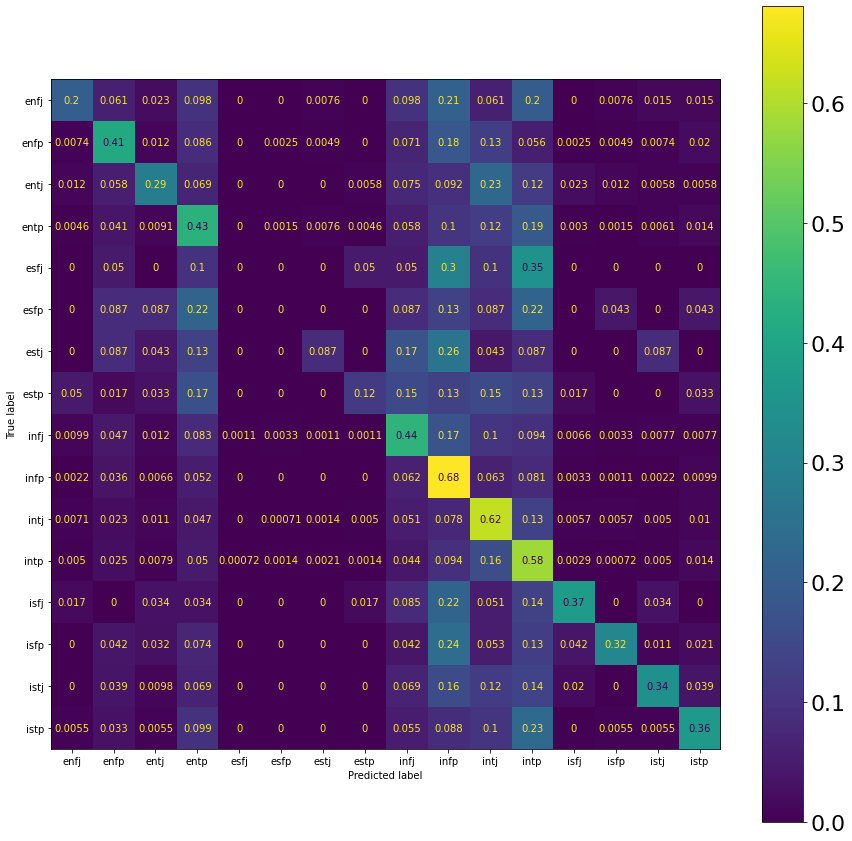

In [63]:
fig, ax = plt.subplots(figsize=(15,15))
plt.rcParams.update({'font.size': 10})
plt.rc('xtick', labelsize=22) 
plt.rc('ytick', labelsize=22) 
plot_confusion_matrix(sgd, X_test_count, y_test, ax=ax, normalize='true')